# First iteration of model - all static values

The first to be defined is a state space, here being set to be discrete values. 
Then the Agent class is defined to set an initial state and a method to "consider" it's state options and possibly changing it's state. 

In [193]:
states = [1, -1] #1 being cooperating, 0 being defecting
threshold = 0
import numpy as np

class Agent:
    def __init__(self, state):
        self.state = state
        self.interactionsReceived = 0
        self.interactionsGiven = 0
    
    def consider(self, neighbour):
        self.interactionsReceived +=1
        neighbour.addInteractionGiven()
        weight = self.state*0.8 + defectorUtility + politicalClimate +  neighboursWeight*neighbour.state
        
        #self.state = np.clip(weight, states[1], states[0])
        
        if(weight > threshold):
            self.state = states[0]
        else:
            self.state = states[1]
            
    def groupConsider(self, neighboursAttitude):
        weight = self.state*0.8 + defectorUtility + politicalClimate +  neighboursWeight*neighboursAttitude
        if(weight > threshold):
            self.state = states[0]
        else:
            self.state = states[1]
    
    def addInteractionGiven(self):
        self.interactionsGiven +=1
        

In [199]:
import matplotlib.pyplot as plt  
import numpy as np

defectorUtility = -0.1
 
politicalClimate=0.1 #Being environment-positive -- Adding some random number being events in life like movies etc.

neighboursWeight = 0.9 # or adding randomness here

The model class consists of the agents and includes a method to make these interact. 

In [212]:
from numpy.random import choice
import random
import matplotlib.pyplot as plt

class Model:
    def __init__(self):
        #Time dependent topology
        self.graph = nx.Graph()
    
    def interact(self, majority = False):
        nodeIndex = random.randint(0, len(self.graph) - 1)
        node = self.graph.nodes[nodeIndex]['agent']
        
        neighbours =  list(self.graph.adj[nodeIndex].keys())
        if(majority):
            neighboursAttitude = 0
            for n in neighbours:
                neighboursAttitude += self.graph.nodes[n]['agent'].state
                neighboursAttitude = neighboursAttitude/len(neighbours)
            if neighboursAttitude > threshold:
                neighboursAttitude = states[0]
            elif neighboursAttitude <= threshold:
                neighboursAttitude = states[1]
            #else:
            #    neighboursAttitude = 0
            node.groupConsider(neighboursAttitude)
        else:
            chosenNeighbourIndex = neighbours[random.randint(0, len(neighbours)-1)]
            chosenNeighbour = self.graph.nodes[chosenNeighbourIndex]['agent']
            node.consider(chosenNeighbour)
        
        
    def countCooperatorRatio(self):
        count = 0
        for node in self.graph:
            if self.graph.nodes[node]['agent'].state > threshold:
                count+=1
        return count/len(self.graph)
        
        

In [196]:
import networkx as nx

def makeGridModel(n):
    model = Model()
    for i in range(n):
        for j in range (n):
            agent1 = Agent(states[random.randint(0,1)])
            model.graph.add_node(i*n+j, agent=agent1, pos=(i, j))
            if(i!=0):
                model.graph.add_edge(i*n+j, (i-1)*n+j)
            if(j!=0):
                model.graph.add_edge(i*n+j, i*n+j-1)
    
    return model

In [170]:
import matplotlib.pyplot as plt



def draw_model(model, save =False, filenumber = None):

    color_map = []
    pos = []
    for node in model.graph:
        pos.append( model.graph.nodes[node]['pos'])
        if model.graph.nodes[node]['agent'].state > threshold:
            color_map.append('#6fe291')
        else: color_map.append('#a50404')   
    
    plt.subplot(121)
    nx.draw(model.graph, pos, node_color = color_map,)
    if(save):
        plt.savefig("plot" + str(filenumber) +".png", bbox_inches="tight")



In [245]:
def radialDist(model, depth, isBefore):
    DefectorValues = [[0 for i in range(depth)] for j in range(len(model.graph))]
    CooperatorValues = [[0 for i in range(depth)] for j in range(len(model.graph))]
    
    for nodeIdx in model.graph:
        neighbours = list(model.graph.adj[nodeIdx])
        isCooperator = model.graph.nodes[nodeIdx]['agent'].state > threshold
        parent = [nodeIdx]
        for d in range(depth):
            nextLevelNeighs = set([])
            for n in neighbours:
                nextLevelNeighs.update(list(model.graph.adj[n]))
                if(model.graph.nodes[n]['agent'].state > threshold and isCooperator):
                    CooperatorValues[nodeIdx][d] += 1
                elif(model.graph.nodes[n]['agent'].state <= threshold and not isCooperator): 
                    DefectorValues[nodeIdx][d] += 1
            CooperatorValues[nodeIdx][d] = CooperatorValues[nodeIdx][d]/len(neighbours)
            DefectorValues[nodeIdx][d] = DefectorValues[nodeIdx][d]/len(neighbours)
            
            #make sure the parent level isn't checked again
            for n in parent:
                nextLevelNeighs.discard(n) 

            parent = neighbours
            neighbours = nextLevelNeighs
     
    cooperatorRatio = model.countCooperatorRatio()
    
    cooperatorRes = []
    defectorRes = []
    for col in range(depth):
        coopSumRatios = 0
        defectSumRatios = 0
        for row in range(len(CooperatorValues)):
            coopSumRatios += CooperatorValues[row][col]
            defectSumRatios += DefectorValues[row][col]
        cooperatorRes.append(np.array(coopSumRatios)/(len(model.graph)*(cooperatorRatio)*cooperatorRatio))
        defectorRes.append(np.array(defectSumRatios)/(len(model.graph)*(1-cooperatorRatio)*(1-cooperatorRatio)))
    #print(cooperatorRes)
    if isBefore:
        intensity = 0.5
    else:
        intensity = 1
    plt.xlabel("Distance from the nodes")
    plt.ylabel("Normalised ratio of agreein neighbours")
    plt.ylim(bottom=0, top =2.7)
    plt.title("Distance distribution function")
    plt.plot(range(1, len(cooperatorRes)+1), cooperatorRes, color=((23/255, 104/255, 37/255, intensity))) 
    plt.plot(range(1, len(cooperatorRes)+1), defectorRes, color=((109/255, 10/255, 10/255, intensity))) 

In [215]:
import imageio

def simulate(n, k, drawModel = False, gifname = None):
    model = makeGridModel(n)
    if(drawModel):
        draw_model(model)
    ratio = []
    filenames = []
    
    radialDist(model, n, True)
    
    for i in range(k):
        model.interact()
        ratio.append(model.countCooperatorRatio())
        if(drawModel and gifname and (i % 20 == 0)):
                draw_model(model, True, i)
                filenames.append("plot" + str(i) +".png")
                #model.graph.add_edge(a, b, weight = weight)
    if(drawModel and gifname ):
        images = []
        for filename in filenames:
            images.append(imageio.imread(filename))
        imageio.mimsave("network" +gifname+ ".gif", images, duration=0.04167)
            
    if(drawModel):
        plt.subplot(122)
        plt.plot(ratio)
        plt.ylabel('Cooperators in %')
        plt.xlabel("Timesteps")
        #plt.subplots_adjust(right=1.2)
        plt.tight_layout( w_pad=0.5)
        plt.show()
    radialDist(model, n, False)

    return (model, ratio)

In [202]:

def batch_simulate(n,k,s):
    batch_proportions=[]
    batch_models = []
    for i in range(s):
        (model, proportion) = simulate(n, k)
        batch_proportions.append(proportion)
        batch_models.append(model)
    return (batch_proportions, batch_models)

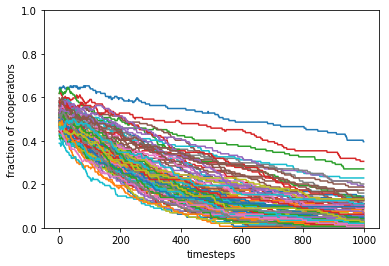

In [210]:

    
(results, models)= batch_simulate(12, 1000, 100)
plt.xlabel("timesteps")
plt.ylabel("fraction of cooperators")
plt.ylim((0, 1))
for i in results:
    plt.plot(i)

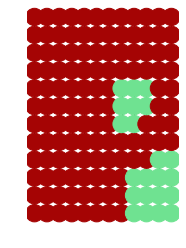

In [206]:
draw_model(models[2])

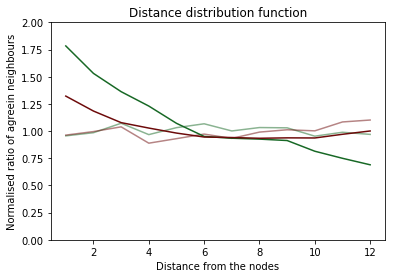

In [231]:
(model, proportion) = simulate(12, 2000)

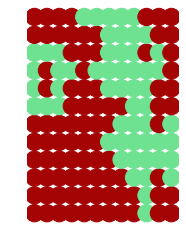

In [232]:
draw_model(model)

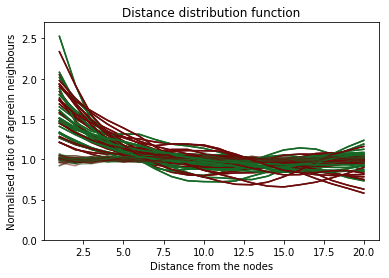

In [246]:
for s in range(20):
    (model, ratio) = simulate(20, 10000)
    radialDist(model, 20, False)
    

In [211]:
(model, ratio) = simulate(12, 3000)

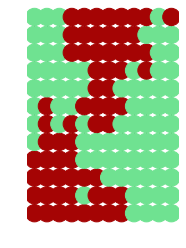

In [159]:
draw_model(model)


{(0, 1): Text(0.0, 0.5, '0.47'),
 (0, 3): Text(0.5, 0.0, '0.35'),
 (1, 2): Text(0.0, 1.5, '0.76'),
 (1, 4): Text(0.5, 1.0, '0.26'),
 (2, 5): Text(0.5, 2.0, '0.18'),
 (3, 4): Text(1.0, 0.5, '0.36'),
 (3, 6): Text(1.5, 0.0, '0.25'),
 (4, 5): Text(1.0, 1.5, '0.76'),
 (4, 7): Text(1.5, 1.0, '0.25'),
 (5, 8): Text(1.5, 2.0, '0.26'),
 (6, 7): Text(2.0, 0.5, '0.62'),
 (7, 8): Text(2.0, 1.5, '0.1')}

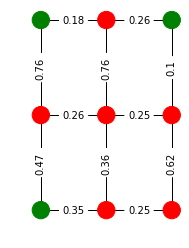

In [235]:
import random 

model = Model()
n = 3
for i in range(n):
    for j in range (n):
        agent1 = Agent(states[random.randint(0,1)])
        model.graph.add_node(i*n+j, agent=agent1, pos=(i, j))
        if(i!=0):
            model.graph.add_edge(i*n+j, (i-1)*n+j, weight=round(random.uniform(0.1, 0.9),2))
        if(j!=0):
            model.graph.add_edge(i*n+j, i*n+j-1, weight = round(random.uniform(0.1, 0.9),2))

    
color_map = []
pos = []
for node in model.graph:
    pos.append(model.graph.nodes[node]['pos'])
    if model.graph.nodes[node]['agent'].state== states[0]:
        color_map.append('green')
    else: color_map.append('red')   

plt.subplot(121)
nx.draw(model.graph, pos=pos, node_color = color_map,)
labels = nx.get_edge_attributes(model.graph,'weight')
nx.draw_networkx_edge_labels(model.graph,pos,edge_labels=labels)

In [132]:
model = makeGridModel(12)

In [134]:
nx.average_shortest_path_length(model.graph)

8.0

In [243]:
print(nx.to_numpy_matrix(model.graph.adj))

AttributeError: 'AdjacencyView' object has no attribute 'is_directed'